In [1]:
from classy import Class
import os, sys, time
import json
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from aemulus_heft.heft_emu import HEFTEmulator
from aemulus_heft.utils import lpt_spectra
from scipy.interpolate import interp1d
from glob import glob
%matplotlib inline

In [2]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius

In [3]:
def convert_for_sim(cparam, omega_nu=0.0006442):
    omega_b = cparam[0]
    omega_c = cparam[1]
    h = cparam[4]
    Omega_b = omega_b/h**2
    Omega_m = (omega_b+omega_c+omega_nu)/h**2
    Omega_de = 1-Omega_m
    A_s = cparam[2] * 1e9
    ln10p10A_s = np.log(1e1*A_s)
    n_s = cparam[3]
    cparam_dict = {'omega_b':omega_b, 'omega_c':omega_c, 'Omega_m':Omega_m,
                   'Omega_b':Omega_b, 'Omega_de':Omega_de, 'h':h,
                   '10^9 A_s':A_s, 'ln(10^10 A_s)':ln10p10A_s, 'n_s':n_s}
    return cparam_dict

def convert_to_zeromnu(cparam):
    cparam_dict = convert_for_sim(cparam)
    omega_b = cparam_dict['Omega_b'] * cparam_dict['h']**2
    omega_c = (cparam_dict['Omega_m']-cparam_dict['Omega_b']) * cparam_dict['h']**2
    As = cparam_dict['10^9 A_s'] * 1e-9
    ns = cparam_dict['n_s']
    h = cparam_dict['h']
    return np.array([omega_b, omega_c, As, ns, h])

In [4]:
def derived_parameters(p, omega_nu):
    #set parameters to configure CLASS computations
    params = {
        'omega_b': p[0],
        'omega_cdm': p[1],
        'A_s': p[2],
        'n_s': p[3], 
        'N_ur': 2.0328,
        'N_ncdm' : 1.0,
        'omega_ncdm' : omega_nu,
#         '100*theta_s' : 1.041533, #from Summit paper
        'h': p[4],
        'recombination' : 'HyRec',
        'tau_reio' : 0.0544,
        'non linear' : 'none',#option for computing non-linear power spectum
        'P_k_max_1/Mpc': 10.0,
        'output': 'mPk' #which quantities we want CLASS to compute
    }
    #initialize Class instance and set parameters
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    h = cosmo.h()
    sigma_8 = cosmo.sigma(8/cosmo.h(),0)
    return h, sigma_8

In [8]:
cparams = np.array([2.22553729e-02, 1.18967357e-01, 2.e-09, 9.91532720e-01,
       6.76225400e-01, 7.27353188e-01])
print(cparams)

[2.22553729e-02 1.18967357e-01 2.00000000e-09 9.91532720e-01
 6.76225400e-01 7.27353188e-01]


In [9]:
cparams_nu0 = convert_to_zeromnu(cparams)
print(cparams_nu0)

[2.22553729e-02 1.19611557e-01 2.00000000e-09 9.91532720e-01
 6.76225400e-01]


In [10]:
1.18967357e-01+0.06/93.12

0.11961168689690721

In [11]:
convert_for_sim(cparams)

{'omega_b': 0.0222553729,
 'omega_c': 0.118967357,
 'Omega_m': 0.31024029984293616,
 'Omega_b': 0.048668943258864124,
 'Omega_de': 0.6897597001570639,
 'h': 0.6762254,
 '10^9 A_s': 2.0,
 'ln(10^10 A_s)': 2.995732273553991,
 'n_s': 0.99153272}

In [12]:
convert_for_sim(convert_to_zeromnu(cparams), omega_nu=0)

{'omega_b': 0.0222553729,
 'omega_c': 0.11961155700000003,
 'Omega_m': 0.3102402998429362,
 'Omega_b': 0.048668943258864124,
 'Omega_de': 0.6897597001570638,
 'h': 0.6762254,
 '10^9 A_s': 2.0,
 'ln(10^10 A_s)': 2.995732273553991,
 'n_s': 0.99153272}

In [13]:
derived_parameters(cparams, omega_nu=0.0006442)

(0.6762254, 0.7965218325129919)

In [14]:
def get_transfer_class(cparam, omega_nu, kh, redshift=1.):
    #set parameters to configure CLASS computations
    params = {
        'omega_b': cparam[0],
        'omega_cdm': cparam[1],
        'A_s': cparam[2],
        'n_s': cparam[3],
        'N_ur': 2.0328,
        'N_ncdm' : 1.0,
        'omega_ncdm' : omega_nu,
#         '100*theta_s' : 1.041533, #from Summit paper
        'h': cparam[4],
        'recombination' : 'HyRec',
        'tau_reio' : 0.0544,
        'z_pk': redshift,
        'non linear' : 'none',#option for computing non-linear power spectum
        'P_k_max_1/Mpc': 10.0,
        'k_pivot': 0.05,
        'output':'tCl,pCl,lCl,mPk,dTk' # Boryana setting
#         'output': 'mPk' #which quantities we want CLASS to compute
    }
    
    #initialize Class instance and set parameters
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    dparams = {'h': cosmo.h(), 'sigma_8': cosmo.sigma(8/cosmo.h(), redshift)}
    
    # Class linear matter power spectrum
    h = cosmo.h()
    pk_lin = np.array([cosmo.pk_lin(ki, redshift) for ki in kh]) * h**3 # in unit of (Mpc/h)^3
    pk_lin_data = {'k [h/Mpc]': kh/h, 'P(k) [(Mpc/h)^3]': pk_lin}
    
    # primordial power spectrum of the scalar perturbations
    A_s = cparam[2]
    n_s = cparam[3]
    k_pivot = params['k_pivot']
    pk_prim = A_s * (kh/k_pivot)**(n_s-1)
    
    # transfer function
    tk = np.sqrt((pk_lin/(h**3) / pk_prim) / (kh**4/(kh**3/(2*np.pi**2))))
    trans_data = {'k [1/Mpc]': kh, 'T(k)': tk}
    
    return trans_data, pk_lin_data, dparams

def get_transfer_class_3deg(cparam, sum_mnu, kh, redshift=1.):
    #set parameters to configure CLASS computations
    params = {
        'omega_b': cparam[0],
        'omega_cdm': cparam[1],
        'A_s': cparam[2],
        'n_s': cparam[3],
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'deg_ncdm': 3,
        'm_ncdm': sum_mnu/3,
        #         '100*theta_s' : 1.041533, #from Summit paper
        'h': cparam[4],
        'recombination' : 'HyRec',
        'tau_reio' : 0.0544,
        'z_pk': redshift,
        'non linear' : 'none',#option for computing non-linear power spectum
        'P_k_max_1/Mpc': 10.0,
        'k_pivot': 0.05,
        'output':'tCl,pCl,lCl,mPk,dTk' # Boryana setting
#         'output': 'mPk' #which quantities we want CLASS to compute
    }
    
    #initialize Class instance and set parameters
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    dparams = {'h': cosmo.h(), 'sigma_8': cosmo.sigma(8/cosmo.h(), redshift)}
    
    # Class linear matter power spectrum
    h = cosmo.h()
    pk_lin = np.array([cosmo.pk_lin(ki, redshift) for ki in kh]) * h**3 # in unit of (Mpc/h)^3
    pk_lin_data = {'k [h/Mpc]': kh/h, 'P(k) [(Mpc/h)^3]': pk_lin}
    
    # primordial power spectrum of the scalar perturbations
    A_s = cparam[2]
    n_s = cparam[3]
    k_pivot = params['k_pivot']
    pk_prim = A_s * (kh/k_pivot)**(n_s-1)
    
    # transfer function
    tk = np.sqrt((pk_lin/(h**3) / pk_prim) / (kh**4/(kh**3/(2*np.pi**2))))
    trans_data = {'k [1/Mpc]': kh, 'T(k)': tk}
    
    return trans_data, pk_lin_data, dparams



In [15]:
## running CLASS for z=1, omega_nu=0
kh = np.geomspace(1e-7,1,1000)
redshift = 1

omega_nu = 0
trans_data0, pk_lin_data0, dparams0 = get_transfer_class(convert_to_zeromnu(cparams), omega_nu, kh, redshift)
dparams0

{'h': 0.6762254, 'sigma_8': 0.4932939108548796}

In [25]:
## running CLASS for z=1, omega_nu=0.0006442
omega_nu = 0.0006442
sum_mnu = 0.06
trans_data, pk_lin_data, dparams = get_transfer_class(cparams, omega_nu, kh, redshift)
print(dparams)

trans_data_3nu, pk_lin_data_3nu, dparams = get_transfer_class_3deg(cparams, sum_mnu, kh, redshift)
print(dparams)

pk_lin_ratio = (pk_lin_data['P(k) [(Mpc/h)^3]'] / pk_lin_data0['P(k) [(Mpc/h)^3]'])
pk_lin_ratio_3nu = (pk_lin_data_3nu['P(k) [(Mpc/h)^3]'] / pk_lin_data0['P(k) [(Mpc/h)^3]'])


{'h': 0.6762254, 'sigma_8': 0.4851854828858218}
{'h': 0.6762254, 'sigma_8': 0.48614584315676623}


## Non-linear power spectra from aemulus-$\nu$

In [22]:
# Compute KECLEFT spectra to use as inputs for HEFT emulator
# (ombh2, ocdmh2, w0, ns, 10^9 As, H0, mnu)
mnu = 0.06
k = kh
cosmo_nu = [cparams[0], cparams[1], -1, cparams[3], cparams[2]*1.e9, cparams[4]*100., mnu]
spec_lpt, sigma8z = lpt_spectra(k, redshift, cosmo_nu)
cosmo_nu.append(sigma8z)
#M_nu = 0, increase ocdmh2 to keep Om constant
cosmo_nu0 = [cparams[0], cparams[1]+mnu/93.12, -1, cparams[3], cparams[2]*1.e9, cparams[4]*100., 0.0]
spec_lpt_nu0, sigma8z_nu0 = lpt_spectra(k, redshift, cosmo_nu0)
cosmo_nu0.append(sigma8z_nu0)

emu = HEFTEmulator()
pnl_nu = emu.predict(k, np.array(cosmo_nu), spec_lpt)
pnl_nu0 = emu.predict(k, np.array(cosmo_nu0), spec_lpt_nu0)

pk_nl_ratio = pnl_nu[0,:]/pnl_nu0[0,:]

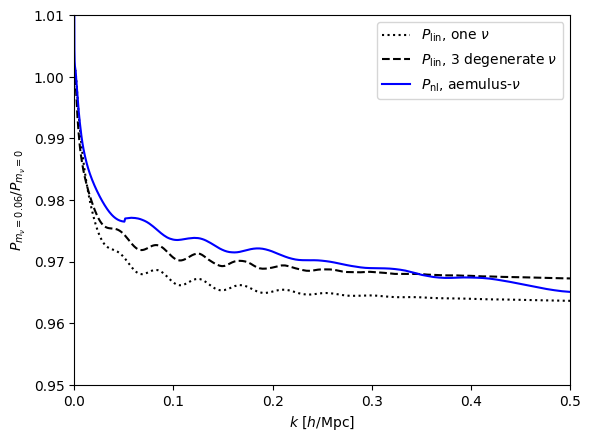

In [26]:
plt.plot(kh,pk_lin_ratio,ls = ':',c = 'k', label = r'$P_{\rm{lin}}$, one $\nu$')
plt.plot(kh,pk_lin_ratio_3nu,ls = '--',c = 'k', label = r'$P_{\rm{lin}}$, 3 degenerate $\nu$')
plt.plot(k, pk_nl_ratio,ls = '-',c = 'b',label = r'$P_{\rm{nl}}$, aemulus-$\nu$')
plt.xlabel(r'$k\,\,[h/\rm{Mpc}]$');
plt.ylabel(r'$P_{m_\nu =0.06}/P_{m_\nu =0}$');
plt.xlim(0,0.5)
plt.ylim(0.95,1.01)
plt.legend()